In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d "dansbecker/cityscapes-image-pairs"

In [ ]:
import zipfile
import os

In [ ]:
zip_ref = zipfile.ZipFile("/content/cityscapes-image-pairs.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import random
import matplotlib.image as mpimg

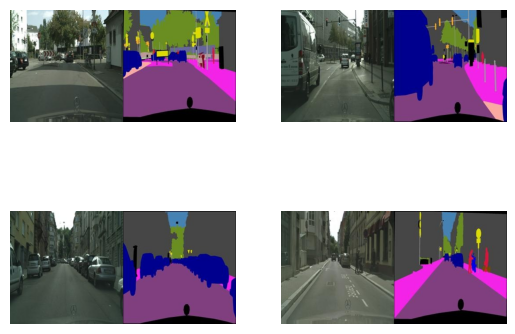

In [ ]:
for i in range(4):
  plt.subplot(2,2,i+1)
  dir = "/content/cityscapes_data/cityscapes_data"
  rand_class = random.choice(os.listdir("/content/cityscapes_data/cityscapes_data"))
  random_image = random.choice(os.listdir(os.path.join(dir,rand_class)))
  img = mpimg.imread(os.path.join(dir,rand_class,random_image))
  img = plt.imshow(img)
  plt.axis(False)

In [ ]:
def preprocess(dir):
  main_dir = "/content/cityscapes_data"+"/"+dir
  x = []
  y = []
  for i in os.listdir(main_dir):

    img = mpimg.imread(main_dir+"/"+i)
    img= tf.image.resize(img,[128,128])
    x.append(img[0:64,0:64]/255.)
    y.append(img[0:64,64:128]/255.)
  return x,y

In [ ]:
x_train,y_train = preprocess("train")

In [ ]:
x_val,y_val = preprocess("val")

In [ ]:
def ConvBlock(x, n_filters):
    x = tf.keras.layers.Conv2D(n_filters, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(n_filters, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

In [ ]:
def downsample_block(x, n_filters):
    f = ConvBlock(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = tf.keras.layers.concatenate([x, conv_features])
    x = tf.keras.layers.Dropout(0.3)(x)
    x = ConvBlock(x, n_filters)
    return x

In [ ]:
inputs = tf.keras.layers.Input(shape=(64, 64, 3))

f1, p1 = downsample_block(inputs, 32)
f2, p2 = downsample_block(p1, 64)
f3, p3 = downsample_block(p2, 128)
f4, p4 = downsample_block(p3, 256)


intermediate_block = ConvBlock(p4, 512)

u6 = upsample_block(intermediate_block, f4, 256)
u7 = upsample_block(u6, f3, 128)
u8 = upsample_block(u7, f2, 64)
u9 = upsample_block(u8, f1, 32)

outputs = tf.keras.layers.Conv2D(3, 1, padding='same', activation='sigmoid')(u9)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [ ]:
his = model.fit(np.array(x_train),np.array(y_train),
                epochs = 60,
                validation_data = (np.array(x_val),np.array(y_val))
                )

In [ ]:
a = model.predict(tf.expand_dims(x_val[2],axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


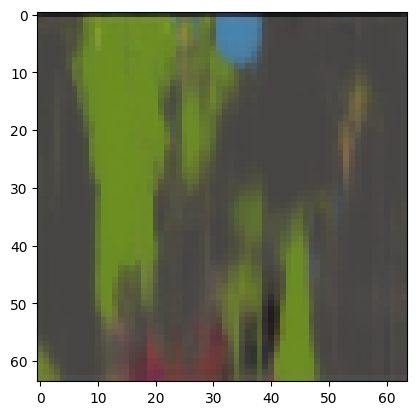

In [ ]:
plt.imshow(tf.squeeze(a))

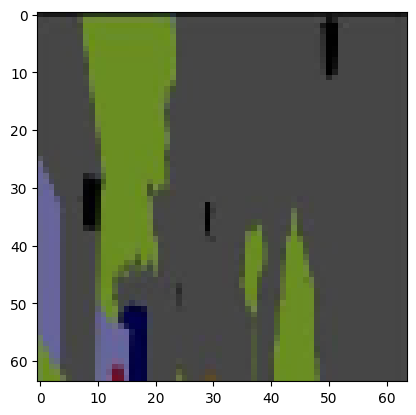

In [ ]:
plt.imshow(y_val[2])